## Final Project Notebook ##

This notebook takes the user through a representative stock in our project. Because we repeated this analysis on many different stocks, we used individual scripts for the modules, rather than one single notebook like this. However, the process is identical and the following notebook will walk you through our methods and rationale for each of our steps. 


In [1]:
import yahoo_finance as yf
import datetime as df
from yahoo_finance import Share
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn import svm
from sklearn import tree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier


from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])

/Users/CL/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**DATA COLLECTION**

These first cells obtain the raw financial data from Yahoo Finance using a package, yahoo-finance, designed for this specific task. Using this raw data, we calculate 7, 50 and 200 day rolling-averages. We then use these rolling averages to calculate 'golden' and 'death' crosses, dates where short term averages cross over long averages. Golden crosses are dates where short term rises above long term averages, and a death cross is where the short term average falls below.

This data is loaded into a final dataframe, used for data integration in the module below.

In [2]:
#loads yahoo-finance data on share described
share=Share('XLV')

In [3]:
#creates dataframe, testf, that contains the historical data. This frame is indexed by day.
test = share.get_historical('2009-01-01','2016-11-14')
testf=pd.DataFrame(test)
testf=testf.set_index(testf['Date'])
testf.index.name=None

#Adds new columns to the dataframe, begin and end, that are datetimes for open and close
testf['Begin'] = pd.to_datetime(testf['Date'].astype(str) + ' 09:30')
testf['End'] = pd.to_datetime(testf['Date'].astype(str) + ' 16:00')
testf=testf.sort_index()
testf.head()

,Adj_Close,Close,Date,High,Low,Open,Symbol,Volume,Begin,End
2009-01-02,23.597654,27.09,2009-01-02,27.23,26.389999,26.559999,XLV,3589100,2009-01-02 09:30:00,2009-01-02 16:00:00
2009-01-05,23.484412,26.959999,2009-01-05,27.120001,26.66,27.120001,XLV,3880700,2009-01-05 09:30:00,2009-01-05 16:00:00
2009-01-06,23.101136,26.52,2009-01-06,27.08,26.299999,27.01,XLV,5726300,2009-01-06 09:30:00,2009-01-06 16:00:00
2009-01-07,22.892076,26.280001,2009-01-07,26.50,26.07,26.07,XLV,3947300,2009-01-07 09:30:00,2009-01-07 16:00:00
2009-01-08,23.022739,26.43,2009-01-08,26.43,25.99,26.15,XLV,5521700,2009-01-08 09:30:00,2009-01-08 16:00:00


In [4]:
#makes a new dataframe using the open time as an index, and open price as the price
start=pd.DataFrame(testf['Open'])
start.columns=(['Price'])
start=start.set_index(testf['Begin'])
start.index.name=None

#makes a new dataframe using the close time as an index, and closing price as the price
end=pd.DataFrame(testf['Close'])
end.columns=(['Price'])
end=end.set_index(testf['End'])
end.index.name=None

#concatenates and sorts these dataframes to create 2x/day price dataframe
grand=pd.concat([start,end])
grand=grand.sort_index()

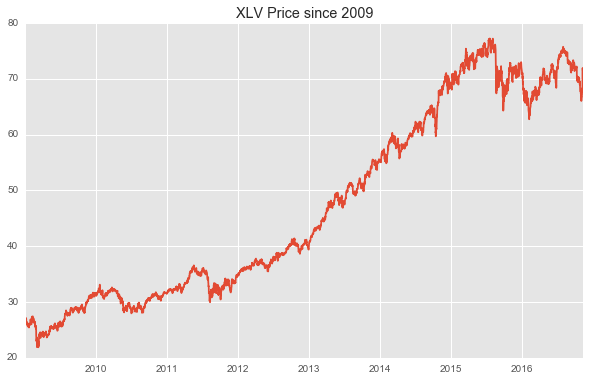

In [5]:
#plots the price over time
plt.plot(grand['Price'])
plt.title('XLV Price since 2009')
plt.show()

In [6]:
#calulate rolling averages (7 day)
grand['7']=grand['Price'].rolling('7d').mean()
#calculate rolling averages (50 day)
grand['50']=grand['Price'].rolling('50d').mean()
#calculate rolling averages (200 day)
grand['200']=grand['Price'].rolling('200d').mean()
grand.head()

,Price,7,50,200
2009-01-02 09:30:00,26.559999,26.559999,26.559999,26.559999
2009-01-02 16:00:00,27.09,26.825000,26.825000,26.825000
2009-01-05 09:30:00,27.120001,26.923333,26.923333,26.923333
2009-01-05 16:00:00,26.959999,26.932500,26.932500,26.932500
2009-01-06 09:30:00,27.01,26.948000,26.948000,26.948000


In [7]:
#creates new columns where data is shifted by one position
grand['7shift']=grand['7'].shift(1)
grand['50shift']=grand['50'].shift(1)
grand['200shift']=grand['200'].shift(1)

#functions to be applied to dataframe, compare n and n-1 states for golden cross
def golden750_cross(row):
    if ((row['7'] >= row['50']) & (row['7shift'] <= row['50shift'])):
        return 1
    else:
        return 0

def golden50200_cross(row):
    if ((row['50'] >= row['200']) & (row['50shift'] <= row['200shift'])):
        return 1
    else:
        return 0
    
def golden7200_cross(row):
    if ((row['7'] >= row['200']) & (row['7shift'] <= row['200shift'])):
        return 1
    else:
        return 0
    
#creates new classfied columns in dataframe, 1 for days where golden crosses occur
grand['750gc']=grand.apply(golden750_cross,axis=1)
grand['50200gc']=grand.apply(golden50200_cross,axis=1)
grand['7200gc']=grand.apply(golden7200_cross,axis=1)

In [8]:
#functions to be applied to dataframe, compare n and n-1 states for golden cross
def golden750_cross(row):
    if ((row['7'] <= row['50']) & (row['7shift'] >= row['50shift'])):
        return 1
    else:
        return 0

def golden50200_cross(row):
    if ((row['50'] <= row['200']) & (row['50shift'] >= row['200shift'])):
        return 1
    else:
        return 0
    
def golden7200_cross(row):
    if ((row['7'] <= row['200']) & (row['7shift'] >= row['200shift'])):
        return 1
    else:
        return 0
    
#creates new binary columns in dataframe, 1 for days where death crosses occur    
grand['750dc']=grand.apply(golden750_cross,axis=1)
grand['50200dc']=grand.apply(golden50200_cross,axis=1)
grand['7200dc']=grand.apply(golden7200_cross,axis=1)

In [9]:
#for each row, calculates the days elapsed since the last golden cross (each window size)
last = 0
def elapsed750(row):
    if row['750gc'] == 0:
        return int(grand.index.get_loc(row.name) - last) / 2
    else:
        global last
        last = grand.index.get_loc(row.name)
        return int(grand.index.get_loc(row.name) - last) / 2
    
#750 crossover elapsed
def elapsed50200(row):
    if row['50200gc'] == 0:
        return int(grand.index.get_loc(row.name) - last) / 2
    else:
        global last
        last = grand.index.get_loc(row.name)
        return int(grand.index.get_loc(row.name) - last) / 2
    
def elapsed7200(row):
    if row['7200gc'] == 0:
        return int(grand.index.get_loc(row.name) - last) / 2
    else:
        global last
        last = grand.index.get_loc(row.name)
        return int(grand.index.get_loc(row.name) - last) / 2

<ipython-input-9-8f67266d2a48>:7: SyntaxWarning: name 'last' is used prior to global declaration
  global last
<ipython-input-9-8f67266d2a48>:16: SyntaxWarning: name 'last' is used prior to global declaration
  global last
<ipython-input-9-8f67266d2a48>:24: SyntaxWarning: name 'last' is used prior to global declaration
  global last


In [10]:
#applies golden cross counting to dataframe
last=0
grand['750g'] = grand.apply(elapsed750,axis=1)

last=0
grand['50200g'] = grand.apply(elapsed50200,axis=1)

last=0
grand['7200g'] = grand.apply(elapsed7200,axis=1)

In [11]:
#for each row, calculates the days elapsed since the last death cross (each window size)
last = 0
def death750(row):
    if row['750dc'] == 0:
        return int(grand.index.get_loc(row.name) - last) / 2
    else:
        global last
        last = grand.index.get_loc(row.name)
        return int(grand.index.get_loc(row.name) - last) / 2
    
#750 crossover elapsed
def death50200(row):
    if row['50200dc'] == 0:
        return int(grand.index.get_loc(row.name) - last) / 2
    else:
        global last
        last = grand.index.get_loc(row.name)
        return int(grand.index.get_loc(row.name) - last) / 2
    
def death7200(row):
    if row['7200dc'] == 0:
        return int(grand.index.get_loc(row.name) - last) / 2
    else:
        global last
        last = grand.index.get_loc(row.name)
        return int(grand.index.get_loc(row.name) - last) / 22

<ipython-input-11-66ea00c63958>:7: SyntaxWarning: name 'last' is used prior to global declaration
  global last
<ipython-input-11-66ea00c63958>:16: SyntaxWarning: name 'last' is used prior to global declaration
  global last
<ipython-input-11-66ea00c63958>:24: SyntaxWarning: name 'last' is used prior to global declaration
  global last


In [12]:
#applies death cross counting to dataframe
last=0
grand['750d'] = grand.apply(death750,axis=1)

last=0
grand['50200d'] = grand.apply(death50200,axis=1)

last=0
grand['7200d'] = grand.apply(death7200,axis=1)

In [13]:
final=grand[['Price','7','50','200','750g','50200g','7200g','750d','50200d','7200d']]
final.head()

,Price,7,50,200,750g,50200g,7200g,750d,50200d,7200d
2009-01-02 09:30:00,26.559999,26.559999,26.559999,26.559999,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-02 16:00:00,27.09,26.825000,26.825000,26.825000,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05 09:30:00,27.120001,26.923333,26.923333,26.923333,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05 16:00:00,26.959999,26.932500,26.932500,26.932500,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-06 09:30:00,27.01,26.948000,26.948000,26.948000,0.0,0.0,0.0,0.0,0.0,0.0


***DATA INTEGRATION***

Our project integrates three different datasets: a financial data set which tracks price, averages and crosses; a sentiment dataset which is Twitter sentiment data; a technical dataset which are metrics calculated from the price data.

These three datasets are initially independent from one another, so we wrote this next module to integrate this data into one dataset.

In [14]:
#loads pre-gathered sentiment data, changes financial data name
sent=pd.read_csv('raw_data/XLV.csv')
sent.index=pd.to_datetime(sent['asof_date'].astype(str) + ' 09:30')
sent.index.name=None
sent_clean=sent[['total_scanned_messages','bull_bear_msg_ratio','bull_minus_bear']]
data=final

In [15]:
#makes a new df, sentiment, that indexes based on sentiment data (1x/day, to 09/2015)
sentiment=data.join(sent_clean, how = 'right', lsuffix='_x')


#makes a new df, finance, that indexes based on financial data (2x/day, to 01/2009)
finance=data.join(sent_clean, how = 'left', lsuffix='_x')


In [16]:
#loads technical data, adds complementary indices, and trims unnecessary data
tech=pd.read_csv('raw_data/XLV_technical_data.csv')
tech.index=pd.to_datetime(tech['Period'].str.replace('00:00:00', '09:30:00'))
techj=tech[['Aroon Oscillator [25]','CMF [20]','MACD (12,26,9) - DIVERGENCE','MACD (12,26,9) - MACD','MACD (12,26,9) - SIGNAL','Williams %R [14]']]

In [17]:
#joins sentiment and technical data, saves to csv
techsent=sentiment.join(techj, how = 'left', lsuffix='_x')
techsent.index.name='date'
techsent.head()

,Price,7,50,200,750g,50200g,7200g,750d,50200d,7200d,total_scanned_messages,bull_bear_msg_ratio,bull_minus_bear,Aroon Oscillator [25],CMF [20],"MACD (12,26,9) - DIVERGENCE","MACD (12,26,9) - MACD","MACD (12,26,9) - SIGNAL",Williams %R [14]
date,,,,,,,,,,,,,,,,,,,
2015-09-20 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-21 09:30:00,71.400002,71.281001,72.615942,73.872101,35.0,939.0,229.5,27.0,8.5,18.5,17,0.25,0.18,-16.0,0.042365,0.264797,-0.717411,-0.982208,-64.763780
2015-09-22 09:30:00,69.010002,71.062000,72.468714,73.849058,36.0,940.0,230.5,28.0,9.5,19.5,19,2.00,0.89,-16.0,0.041341,0.171523,-0.767804,-0.939327,-73.228346
2015-09-23 09:30:00,69.599998,70.689001,72.264428,73.826967,37.0,941.0,231.5,29.0,10.5,20.5,11,4.00,-0.06,-12.0,0.086542,0.108165,-0.804121,-0.912286,-74.606299
2015-09-24 09:30:00,68.900002,70.209001,72.049000,73.793692,38.0,942.0,232.5,30.0,11.5,21.5,16,0.75,-0.68,-8.0,0.026330,0.025790,-0.880048,-0.905838,-85.338795


***DATA CORRELATIONS***

Before we tried to use this data to predict stock movement, we wanted to examine correlations between the different sets of data. To do this, we looked at the correlation between price, the technical MACD, and a 7-day rolling average of the 'bull_minus_bear' sentiment metric.

XLV                           Price         7  MACD (12,26,9) - MACD
Price                  1.000000  0.408704               0.663143
7                      0.408704  1.000000               0.613733
MACD (12,26,9) - MACD  0.663143  0.613733               1.000000


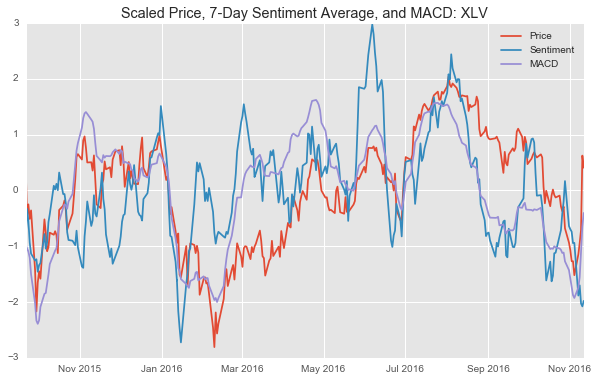

In [18]:
#scales the integrated data, then plots sentiment, technical, and financial data simultaneously
#also calculates the correlations between each dataset
XLL=pd.read_csv('org_data/XLV_technicals.csv')
XLL.index=pd.to_datetime(XLL['date'])
del XLL['date']
XLL['7']=XLL['bull_minus_bear'].rolling('14d').mean()
XL=XLL[XLL['Williams %R [14]'] < 0]
X=pd.DataFrame(scale(XL))
X.columns=XL.columns
X.index=XL.index
print('XLV', X[['Price','7','MACD (12,26,9) - MACD']].corr())
    
plt.plot(X.index,X['Price'],label='Price')
plt.plot(X.index,X['7'],label='Sentiment')
plt.plot(X.index,X['MACD (12,26,9) - MACD'],label='MACD')
plt.legend()
plt.title('Scaled Price, 7-Day Sentiment Average, and MACD: XLV')
plt.show()

Based on this analysis, sentiment and MACD are ~60% correlated, while sentiment and price are only 40% correlated. This implies that the sentiment analysis is attached to the movement of the stock, but may provide novel data for predictions as the correlation between sentiment and price varies from the correlation between MACD and price. This is a comforting results prior to modeling.

***MODELING***

**Classifer Creation**

We now want to use this integrated dataset to see if we can predict the how a stock will move from one day or another. We created a classified variable so we could use machine learning as predictive tool. This classified variable will be 1 if the price on Day N rises above Day N-1, a -1 if the opposite is true, and 0 if the stock does not vary outside of our set threshold, which is .7%.

In [19]:
#Loads integrated data, defines X dataframe for modeling
sent=pd.read_csv('org_data/XLV_technicals.csv',index_col=0) #this is the variable techsent
tryt=sent[['Price','7','50','200','bull_bear_msg_ratio','bull_minus_bear','CMF [20]','MACD (12,26,9) - MACD','Williams %R [14]']]
X=tryt[tryt['Price'] > 0]
Xi=sent[sent['Price'] > 0][['Price','7','50','200','750g','50200g','7200g','750d','50200d','7200d','bull_bear_msg_ratio','bull_minus_bear']]
Xt=sent[sent['Price'] > 0][['Price','CMF [20]','MACD (12,26,9) - MACD','Williams %R [14]']]

In [20]:
#function to create categorical variable, based on .7% threshold for neutral
def tester(row):
    if row['Price'] > row['PS'] * 1.007:
        return 1
    elif row['Price'] < row['PS'] * .993:
        return -1
    else:
        return 0

In [21]:
#creates new categorical variable based on shift (how many days out to predict)
X['PS']=X['Price'].shift(1)

X['Move']=X.apply(tester,axis=1)

del X['PS']

y=X['Move']

/Users/CL/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/CL/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**Preliminary parameterization visualization**

We first wanted to understand what patterns we may observe using our different machine learning models. How well do these classifiers work? What happens if we vary a parameter of the model?

We varied the number of neighbors for kNN, C for svm and max_depth for a decision tree model. For each of these variables, we calculated prediction accuracy on a test dataset and plotted this accuracy for each variation. These plots are below.

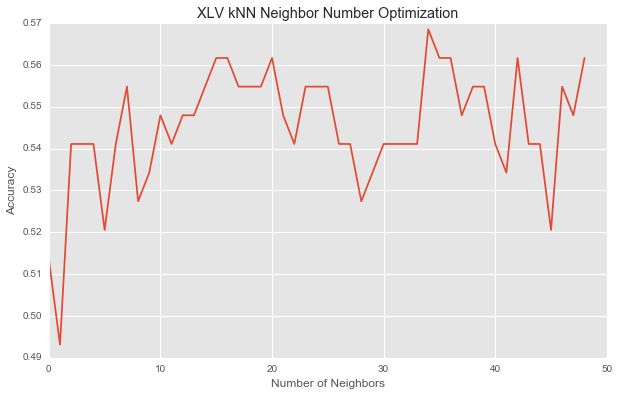

0.554794520548
[[12 19  1]
 [14 65  3]
 [ 2 26  4]]


In [22]:
#Visualization of accuracy for kNN on full dataset

XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.5)
number=[]
for i in range(1,50):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(XTrain, yTrain)
    y_pred=model.predict(XTest)
    number.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

plt.plot(number)
plt.title('XLV kNN Neighbor Number Optimization')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.savefig('graphs/XLV_Knn_1day_06.pdf')
plt.show()

#accuracy and confusion matrix for n nearest neighbors
model = KNeighborsClassifier(n_neighbors = 8)
model.fit(XTrain, yTrain)
y_pred=model.predict(XTest)
print(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

For this dataset, the most optimal number of neighbors for the kNN model was 8.

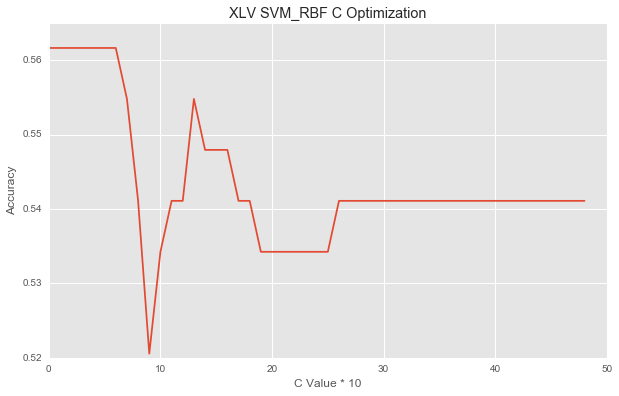

0.541095890411
[[ 5 26  1]
 [ 5 72  5]
 [ 1 29  2]]


In [23]:
#same check for SVM(rbf kernel)
number=[]
for i in range(1,50):
    model = svm.SVC(kernel='rbf',C=i/10)
    model.fit(XTrain, yTrain)
    y_pred=model.predict(XTest)
    number.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

plt.plot(number)
plt.title('XLV SVM_RBF C Optimization')
plt.xlabel('C Value * 10')
plt.ylabel('Accuracy')
plt.savefig('graphs/XLV_svm_1day_06.pdf')
plt.show()

model = svm.SVC(kernel='rbf',C=1.3)
model.fit(XTrain, yTrain)
y_pred=model.predict(XTest)
print(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

For this dataset, the optimal C value for the rbf kernel of svm was < 1.

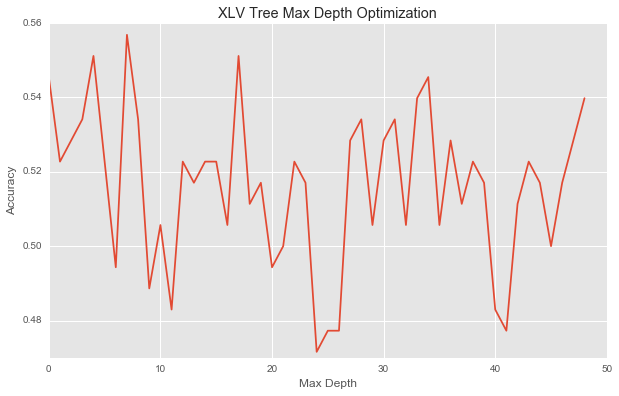

0.522727272727
[[ 0 39  1]
 [ 0 91  5]
 [ 0 39  1]]


In [34]:
#testing module for Decision Tree. Parameterized on depth. 
number=[]
for i in range(1,50):
    model = tree.DecisionTreeClassifier(max_depth=i)
    model.fit(XTrain, yTrain)
    y_pred=model.predict(XTest)
    number.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

plt.plot(number)
plt.title('XLV Tree Max Depth Optimization')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
#plt.savefig('graphs/XLV_tree_1day_06.pdf')
plt.show()

#accuracy and confusion matrix for n depth
model = tree.DecisionTreeClassifier(max_depth=2)
model.fit(XTrain, yTrain)
y_pred=model.predict(XTest)
print(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

For this dataset, the optimal max_depth for a decision tree model was 2.

**PCA and k-Means Clustering**

To observe if our data had any obvious patterns associated with upward or downward movement, we condensed the data using PCA, plotted the first two principal componenets, and then colored these datapoints by the classifier status.

In [25]:
#Creates PCA from input data, calculates explained variance
pca_model = PCA()
X_PCA = pca_model.fit_transform(X)

# create a new pandas dataframe 
XP=pd.DataFrame(X_PCA)
XP.index.name=None


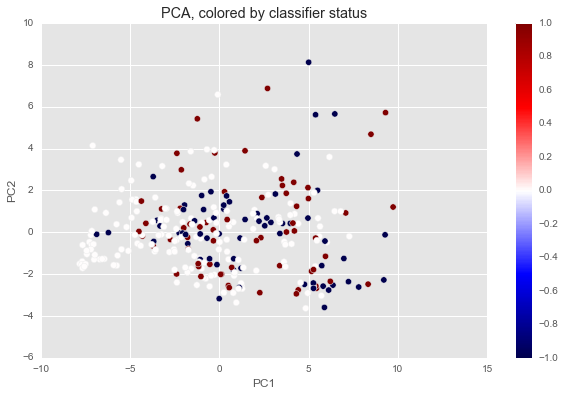

In [26]:
plt.scatter(XP[1],XP[2],c=y,cmap='seismic',s=40)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.title('PCA, colored by classifier status')
#plt.savefig('PCA_by_classifier.pdf')
plt.show()

We also performed a clustering analysis to examine if the data had any obvious patterns that correlated with the classifier status. We parameterized our clustering model and examined the inertia of each number of clusters. We found there was no change in inertia after about 4 clusters, so we plotted the dataset on the first two principal components, colored by each of the 4 clusters.

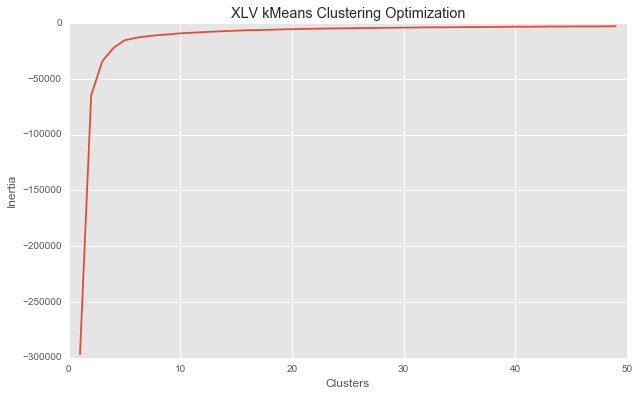

In [27]:
#clustering parameterization for number of clusters
ks=[]
scores=[]
for i in range(1,50):
    model = KMeans(n_clusters=i)
    model.fit_predict(X)
    scores.append(model.score(X))
    ks.append(i)

plt.plot(ks, scores)
plt.title('XLV kMeans Clustering Optimization')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
#plt.savefig('org_data/XLV_kMeans')
plt.show()

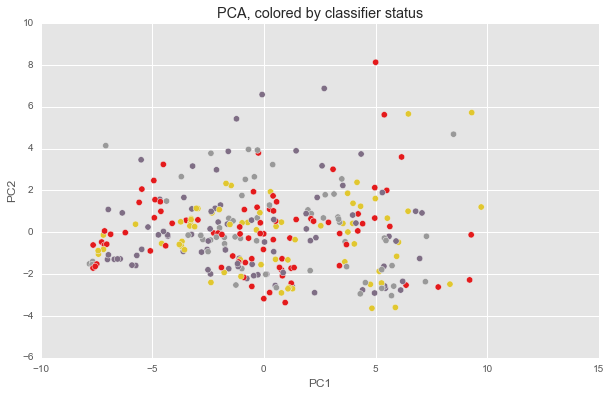

In [28]:
#plotting datapoints with kMeans Clustering
model = KMeans(n_clusters=4)
y_pred=model.fit_predict(X)


plt.scatter(XP[1],XP[2],c=y_pred,cmap='Set1',s=40)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA, colored by classifier status')
#plt.savefig('PCA_by_classifier.pdf')
plt.show()

**Test of Datasets and Model Types**

With this initial data in hand, we turned toward predicting the movement of this stock. We wanted to see if our prediction accuracy varied with different datasets (Does prediction rise if we incorporate sentiment?) and different models (What model best predicts the data?).

We separated the conjoined dataset into constitutent parts, then parameterized each model individually for the dataset. The highest prediction accuracy for each model and dataset was recorded, then plotted below. Model/dataset combinations with higher accuracy are redder, while lower accuracy combinations are bluer.

In [29]:
#separates the full dataset into constituent parts
alls=X
y=X['Move']
del alls['Move']
allsent=alls[['Price','7','50','200','bull_bear_msg_ratio','bull_minus_bear']]
ratio= alls[['Price','7','50','200','bull_bear_msg_ratio']]
minus= alls[['Price','7','50','200','bull_minus_bear']]
averages=alls[['Price','bull_bear_msg_ratio','bull_minus_bear']]
price=pd.DataFrame(alls['Price'])
lists=[allsent,ratio,minus,averages,price,Xi,Xt]

In [30]:
#make a module to test all three different modeling paradigms, and pick the max from each parameter space
score=[]

for data in lists:
    test=[]
    XTrain, XTest, yTrain, yTest = train_test_split(data, y, train_size=0.4)
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[.1, 10]}
    svr = svm.SVC()
    clf = GridSearchCV(svr, parameters,cv=5)
    clf.fit(XTrain, yTrain)
    y_pred=clf.predict(XTest)
    test.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
    
    parameters = {'n_neighbors':[1, 20]}
    kNN = KNeighborsClassifier()
    clf = GridSearchCV(kNN, parameters,cv=5)
    clf.fit(XTrain, yTrain)
    y_pred=clf.predict(XTest)
    test.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
   
    parameters = {'max_depth':[1, 20]}
    trees = tree.DecisionTreeClassifier()
    clf = GridSearchCV(trees, parameters,cv=5)
    clf.fit(XTrain, yTrain)
    y_pred=clf.predict(XTest)
    test.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
    
    score.append(test)
   
    
#builds the results into a dataframe for plotting
scores=pd.DataFrame(score,columns=['svm','kNN','tree'],index=['sentiment','ratio','minus','sent only','price','crosses','techs'])
print(scores)

                svm       kNN      tree
sentiment  0.698864  0.596591  0.539773
ratio      0.630682  0.534091  0.528409
minus      0.619318  0.522727  0.534091
sent only  0.551136  0.562500  0.551136
price      0.551136  0.505682  0.539773
crosses    0.607955  0.562500  0.471591
techs      0.545455  0.545455  0.545455


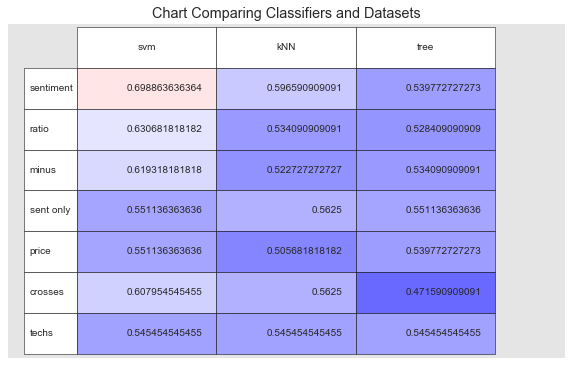

In [31]:
#plots the model tests on a table, colored by accuracy
vals=scores.values
cols=scores.columns
rows=scores.index
fig=plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
the_table = ax.table(cellText=vals,
          colLabels=cols, rowLabels=rows,
          loc='center',cellColours=plt.cm.seismic(vals*.75))
the_table.scale(.75, 3.4)
plt.title('Chart Comparing Classifiers and Datasets')
#plt.savefig("XLV_model.pdf")
plt.show()

In this example, the highest prediction accuracy was acquired by including all sentiment data. This indicated to us that sentiment analysis was almost certainly useful for predictive models. However, because this was just one stock, our data was limited.

***FINAL ANALYSIS***

Because we could not draw robust conclusions from only one stock, we repeated the above analysis on six different ETFs to see if the patterns we found in the XLV dataset held true across multiple datasets.

We created a dataframe of the results from each stock, and recorded which model and dataset had the best prediction. As a way of rudimentarily controlling for the natural variation present in each stock, we considered the accuracy difference between incorporating other data (sentiment or technicals) and price alone. We then correlated this difference with different input paramters for each stock.

In [32]:
#reads final results file, loads to pandas dataframe
final=pd.read_csv('final_results.csv',index_col=0)
final

,total_scanned_messages,bull_bear_msg_ratio,bull_minus_bear,Highest prediction,Method,Dataset,Highest Pred. - Price Pred.
stock,,,,,,,
XLB,7.326190,0.483945,0.316739,0.683,svm,ratio,0.203
XLE,40.678571,2.057932,0.098845,0.591,svm,minus,0.256
XLF,27.540476,1.865588,0.194076,0.646,svm,minus,0.143
XLI,6.745238,0.410230,0.484527,0.661,svm,ratio,0.017
XLP,8.340476,0.559881,0.721154,0.723,svm,techs,0.074
XLV,11.130952,1.047492,0.510566,0.688,svm,allsent,0.063


                             total_scanned_messages  bull_bear_msg_ratio  \
total_scanned_messages                     1.000000             0.957192   
bull_bear_msg_ratio                        0.957192             1.000000   
bull_minus_bear                           -0.799141            -0.762339   
Highest prediction                        -0.866778            -0.773034   
Highest Pred. - Price Pred.                0.696418             0.592055   

                             bull_minus_bear  Highest prediction  \
total_scanned_messages             -0.799141           -0.866778   
bull_bear_msg_ratio                -0.762339           -0.773034   
bull_minus_bear                     1.000000            0.887572   
Highest prediction                  0.887572            1.000000   
Highest Pred. - Price Pred.        -0.784764           -0.614420   

                             Highest Pred. - Price Pred.  
total_scanned_messages                          0.696418  
bull_bear_msg_ra

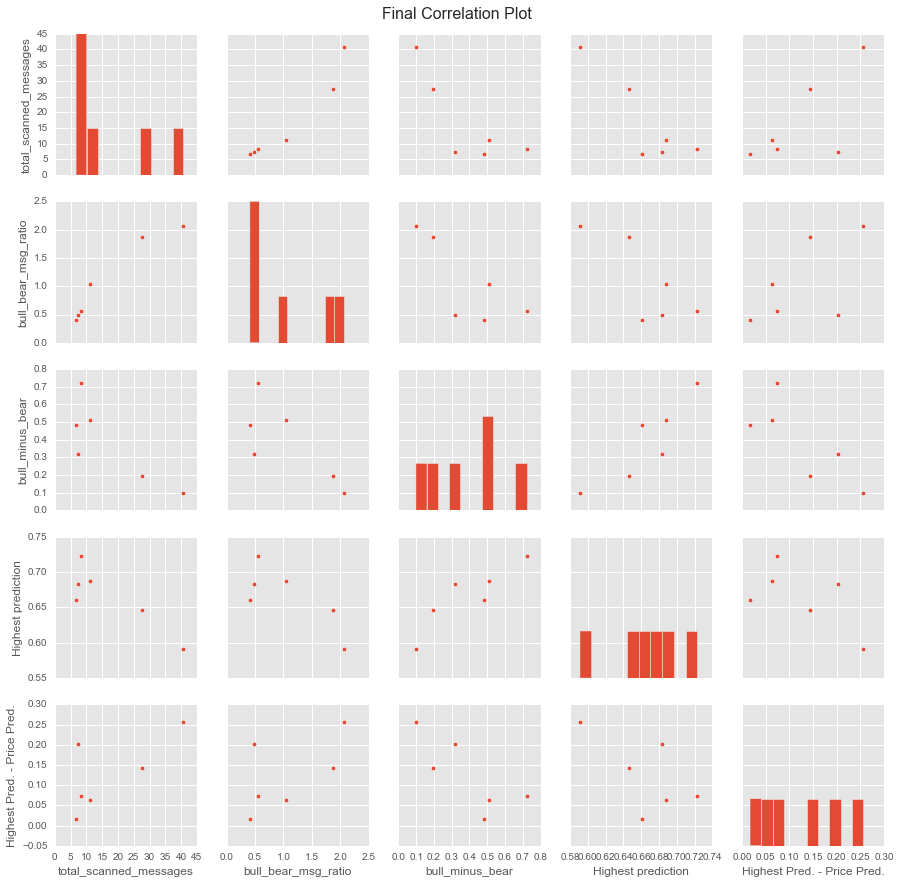

In [33]:
print(final.corr())
g=sns.pairplot(final)
plt.subplots_adjust(top=.95)
g.fig.suptitle('Final Correlation Plot', size=16)
#plt.savefig('final_pairplot.pdf')
plt.show()

Here, we find that the average number of daily tweets ('total_scanned_messages'), as well as the ratio between positive and negative tweets (bull_bear_msg_ratio) both correlated quite positively with the difference between the best prediction and the price prediction for each stock.

These results, in sum, suggested to us that not only was sentiment data a useful addition to predictive models for a majority of the stocks we tested, but implies that the more twitter data that exists for each stock, the more that sentiment analysis contributes to the accuracy of the model.

We can conclude that sentiment analysis, if obtainable, is almost certainly a positive contribution to models for stock movement prediction.